In [16]:
# BASE_PATH = '/kaggle/input/dis-project-2-recommender-systems-f2024/'
BASE_PATH = './'

In [17]:

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse.linalg import svds

In [18]:
books_df = pd.read_csv(f'{BASE_PATH}/books.csv')
df_test =  pd.read_csv(f'{BASE_PATH}/test.csv')
df_train = pd.read_csv(f'{BASE_PATH}/train.csv')

# Basic Exploration
print("Training data shape:", df_train.shape)
print("Unique users:", df_train.user_id.nunique())
print("Unique books:", df_train.book_id.nunique())

Training data shape: (100523, 3)
Unique users: 18905
Unique books: 15712


In [19]:
def map_ids(data, column_name):
    """Map data IDs to zero-based indices"""
    unique_ids = data[column_name].unique()
    id_to_index = {old: new for new, old in enumerate(unique_ids)}
    return data[column_name].map(id_to_index), id_to_index

# Applying the mapping function to both train and test data
df_train['user_id'], user_mapping = map_ids(df_train, 'user_id')
df_train['book_id'], book_mapping = map_ids(df_train, 'book_id')
#test_data['user_id'] = test_data['user_id'].map(user_mapping)
#test_data['book_id'] = test_data['book_id'].map(book_mapping)

n_users = df_train['user_id'].nunique()
n_books = df_train['book_id'].nunique()

custom_df_test = df_test.copy()

custom_df_test['user_id'] = custom_df_test['user_id'].map(user_mapping)
custom_df_test['book_id'] = custom_df_test['book_id'].map(book_mapping)

In [20]:
import numpy as np
from collections import defaultdict

class BiasPredictor:
    def __init__(self, store_loss=False):
        self.global_mean = 0
        self.user_biases = defaultdict(float)
        self.item_biases = defaultdict(float)
        self.store_loss = False
        if store_loss:
            self.store_loss = True
            self.train_losses = []
            self.val_losses = []


        
    def fit(self, ratings_data, n_epochs=10, learning_rate=0.01, reg_term=0.1, monitor_reg=False):
        # Calculate global mean
        ratings = [r for _, _, r in ratings_data]
        self.global_mean = np.mean(ratings)
        
        # Train biases using SGD
        for epoch in range(n_epochs):
            total_error = 0
            np.random.shuffle(ratings_data)
            
            for user_id, item_id, rating in ratings_data:
                # Compute current prediction
                pred = self.global_mean + self.user_biases[user_id] + self.item_biases[item_id]
                
                # Compute error
                error = rating - pred

                if monitor_reg:
                    total_error += error ** 2 + reg_term * (self.user_biases[user_id] ** 2 + self.item_biases[item_id] ** 2)
                else:
                    total_error += error ** 2

                # Update biases
                self.user_biases[user_id] += learning_rate * (error - reg_term * self.user_biases[user_id])
                self.item_biases[item_id] += learning_rate * (error - reg_term * self.item_biases[item_id])

            print(f"Epoch {epoch + 1}, RMSE: {np.sqrt(total_error / len(ratings_data))}")


    def fit_with_validation(self, ratings_data, validation_data, n_epochs=10, learning_rate=0.01, reg_term=0.1,
                           patience=5, monitor_reg=False):
        # Calculate global mean
        ratings = [r for _, _, r in ratings_data]
        self.global_mean = np.mean(ratings)
        
        # Train biases using SGD

        best_validation_error = 1e9

        reset_counter = 0
        
        for epoch in range(n_epochs):
            total_error = 0
            np.random.shuffle(ratings_data)
            
            for user_id, item_id, rating in ratings_data:
                # Compute current prediction
                pred = self.global_mean + self.user_biases[user_id] + self.item_biases[item_id]
                
                # Compute error
                error = rating - pred

                if monitor_reg:
                    total_error += error ** 2 + reg_term * (self.user_biases[user_id] ** 2 + self.item_biases[item_id] ** 2)
                else:
                    total_error += error ** 2

                
                # Update biases
                self.user_biases[user_id] += learning_rate * (error - reg_term * self.user_biases[user_id])
                self.item_biases[item_id] += learning_rate * (error - reg_term * self.item_biases[item_id])


            # compute validation error
            validation_error = 0
            for user_id, item_id, rating in validation_data:
                pred = self.global_mean + self.user_biases[user_id] + self.item_biases[item_id]

                error = rating - pred
                validation_error += error ** 2

            if validation_error < best_validation_error:
                reset_counter = 0
                best_validation_error = validation_error
            else:
                reset_counter += 1

            if self.store_loss:
                self.train_losses.append(np.sqrt(total_error / len(ratings_data)))
                self.val_losses.append(np.sqrt(validation_error / len(validation_data)))

            print(f"Epoch {epoch + 1}, Train RMSE: {np.sqrt(total_error / len(ratings_data)):.3f} Valid RMSE: {np.sqrt(validation_error/ len(validation_data)):.3f} (Best: {np.sqrt(best_validation_error/len(validation_data)):.3f}) Counter: {reset_counter}")

            if reset_counter > patience:
                print(f"Breaking at epoch {epoch}")
                break
    
    def predict(self, user_id, item_id):
        """Predict rating for a user-item pair"""
        return self.global_mean + self.user_biases[user_id] + self.item_biases[item_id]

In [21]:
train_tuples = [(int(x[0]), int(x[1]), float(x[2])) for x in df_train.to_numpy()]
len(train_tuples), train_tuples[0]

(100523, (0, 0, 3.5))

In [22]:
def evaluate_rmse(model, data):
    squared_errors = []
    for user_id, item_id, rating in data:
        pred = model.predict(user_id, item_id)
        squared_errors.append((rating - pred) ** 2)
    return np.sqrt(np.mean(squared_errors))

In [23]:
all_models = []
all_train_losses = {}
all_val_losses = {}
from sklearn.model_selection import train_test_split
for k in range(5):
    baseline_model = BiasPredictor(store_loss=True)

    sub_train_data, val_data = train_test_split(train_tuples, test_size=0.2, random_state=k)

    baseline_model.fit_with_validation(sub_train_data, val_data, n_epochs=100)

    all_train_losses[k] = baseline_model.train_losses
    all_val_losses[k] = baseline_model.val_losses

    all_models.append(baseline_model)
    

Epoch 1, Train RMSE: 1.062 Valid RMSE: 1.043 (Best: 1.043) Counter: 0
Epoch 2, Train RMSE: 0.996 Valid RMSE: 1.009 (Best: 1.009) Counter: 0
Epoch 3, Train RMSE: 0.953 Valid RMSE: 0.986 (Best: 0.986) Counter: 0
Epoch 4, Train RMSE: 0.922 Valid RMSE: 0.971 (Best: 0.971) Counter: 0
Epoch 5, Train RMSE: 0.896 Valid RMSE: 0.958 (Best: 0.958) Counter: 0
Epoch 6, Train RMSE: 0.875 Valid RMSE: 0.949 (Best: 0.949) Counter: 0
Epoch 7, Train RMSE: 0.856 Valid RMSE: 0.941 (Best: 0.941) Counter: 0
Epoch 8, Train RMSE: 0.840 Valid RMSE: 0.935 (Best: 0.935) Counter: 0
Epoch 9, Train RMSE: 0.826 Valid RMSE: 0.929 (Best: 0.929) Counter: 0
Epoch 10, Train RMSE: 0.813 Valid RMSE: 0.924 (Best: 0.924) Counter: 0
Epoch 11, Train RMSE: 0.801 Valid RMSE: 0.920 (Best: 0.920) Counter: 0
Epoch 12, Train RMSE: 0.790 Valid RMSE: 0.917 (Best: 0.917) Counter: 0
Epoch 13, Train RMSE: 0.780 Valid RMSE: 0.914 (Best: 0.914) Counter: 0
Epoch 14, Train RMSE: 0.771 Valid RMSE: 0.911 (Best: 0.911) Counter: 0
Epoch 15, Train

In [35]:


sns.utils.ci(sns.algorithms.bootstrap([5.5, 3.3]))


array([3.3, 5.5])

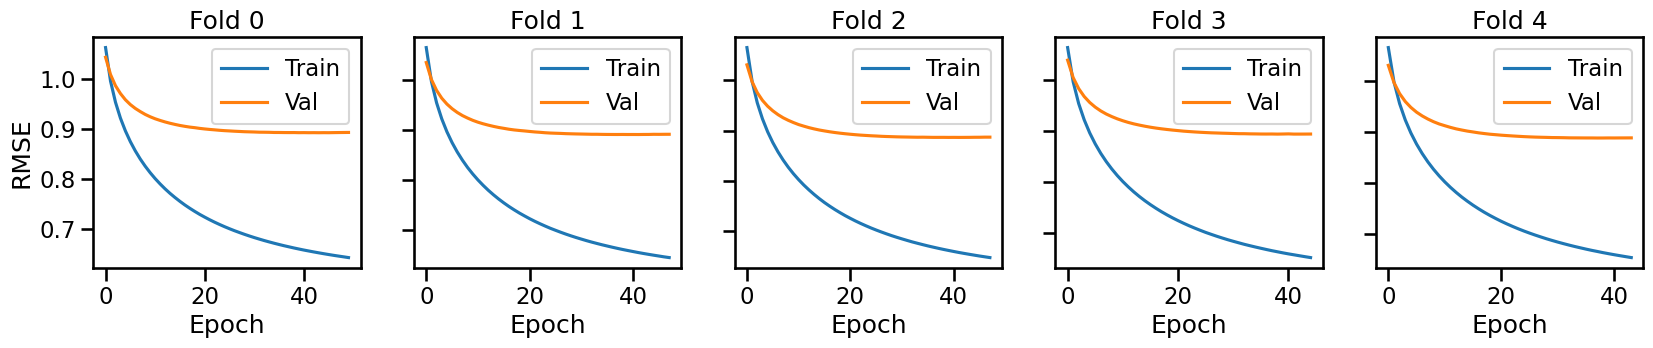

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

fig, ax = plt.subplots(1, 5, figsize=(20,3))

for k in range(5):
    sns.lineplot(x=range(len(all_train_losses[k])), y=all_train_losses[k], ax=ax[k], label='Train')
    sns.lineplot(x=range(len(all_val_losses[k])), y=all_val_losses[k], ax=ax[k], label='Val')
    ax[k].set_title(f"Fold {k}")
    ax[k].set_xlabel("Epoch")
    if k == 0:
        ax[k].set_ylabel("RMSE")

    if k > 0:
        ax[k].set_yticklabels([])
    ax[k].legend()

# plt.tight_layout()
plt.savefig('fold_loss_curves.pdf', bbox_inches='tight')




In [12]:
custom_test_tuples = [(int(x[1]), int(x[2]), -1) for x in custom_df_test.to_numpy()]

In [13]:
preds = []
for user_id, item_id, rating in custom_test_tuples:
    pred = 0
    for model in all_models:
        model_pred = model.predict(user_id, item_id)
        pred += model_pred
    pred = pred / 5
    preds.append(pred)

In [14]:
submission_df = df_test.copy()
submission_df = submission_df.drop(['book_id', 'user_id'], axis=1)
submission_df['rating'] = preds

In [15]:
submission_df.head()

,id,rating
0,0,1.957814
1,1,2.008386
2,2,1.370347
3,3,2.367723
4,4,2.384439


In [12]:
submission_df.head()

,id,rating
0,0,1.959519
1,1,2.005657
2,2,1.364444
3,3,2.377260
4,4,2.380715


In [13]:
submission_df.to_csv('submission.csv', index=False)